Net GHG/Revenue Impact of Load-Shifting Batteries

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.optimization.models import MultiScenarioOptimization, SimulationOptimization
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatterySchedule
from load.customer.models import Meter

In [3]:
# define battery specs and schedule

# create 5 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=5, discharge_duration=timedelta(hours=2), efficiency=0.9)
config_1, _ = BatteryConfiguration.get_or_create_from_battery(battery)

# create 10 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=10, discharge_duration=timedelta(hours=2), efficiency=0.86)
config_2, _ = BatteryConfiguration.get_or_create_from_battery(battery)

# only charge on NEM exports
charge_schedule, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(0, 0, 0, 0))
# always discharge between 4 p.m. and 9 p.m.
discharge_schedule, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(16, 22, 0, float("inf")))

# view schedules
# display(charge_schedule.frame288.dataframe)
# display(discharge_schedule.frame288.dataframe)

In [4]:
# create multi-scenario optimization
multi = MultiScenarioOptimization.objects.create()

# run simulation optimization
for config in [config_1, config_2]:
    single, _ = SimulationOptimization.objects.get_or_create(
        start=datetime(2018, 1, 1),
        end_limit=datetime(2019, 1, 1),
        charge_schedule=charge_schedule,
        discharge_schedule=discharge_schedule,
        battery_configuration=config,
        rate_plan=RatePlan.objects.get(name="E-1 - Baseline Region Q")
    )
    single.meters.add(*Meter.objects.all())
    single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
    single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
    multi.simulation_optimizations.add(single)
    
multi.run(multiprocess=True)

In [5]:
# display bill and GHG impacts
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,SimulationRatePlan,MeterRatePlan
SA_ID,,,,,,,,,,
0,13.590963,0.009779,-0.031470,-0.023757,-0.107685,0.016451,1,5kW @ 2 hours (90.0% efficiency),E-1 - Baseline Region Q,TEST
0,19.119602,0.015926,-0.025513,-0.017664,-0.101805,0.023154,2,10kW @ 2 hours (86.0% efficiency),E-1 - Baseline Region Q,TEST
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,5kW @ 2 hours (90.0% efficiency),E-1 - Baseline Region Q,"E19, Medium General Service, Primary"
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,10kW @ 2 hours (86.0% efficiency),E-1 - Baseline Region Q,"E19, Medium General Service, Primary"
8943913372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,5kW @ 2 hours (90.0% efficiency),E-1 - Baseline Region Q,"EV, Residential Rates for Electric Vehicle Owners"
8943913372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,10kW @ 2 hours (86.0% efficiency),E-1 - Baseline Region Q,"EV, Residential Rates for Electric Vehicle Owners"


In [6]:
# remove all existing filters
multi.reinitialize()

# filter simulations
multi.filter_by_query("BillDelta > 0")  # remove BillDelta less than or equal to 0
multi.filter_by_transform("CleanNetShort2022Delta", min)  # limit results to min CleanNetShort2022Delta values 

In [7]:
# display bill and GHG impacts
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,SimulationRatePlan,MeterRatePlan
0,13.590963,0.009779,-0.03147,-0.023757,-0.107685,0.016451,1,5kW @ 2 hours (90.0% efficiency),E-1 - Baseline Region Q,TEST


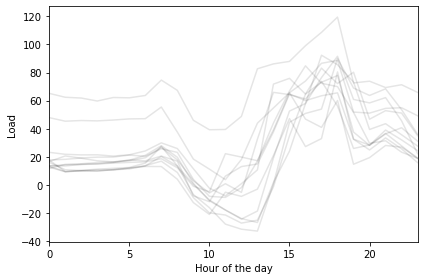

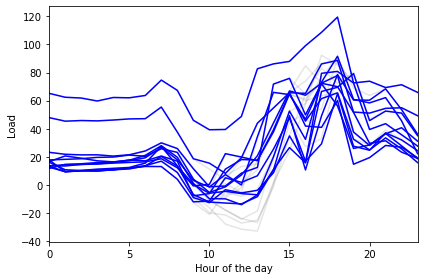

In [8]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.aggregate_pre_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.aggregate_pre_intervalframe, frame288_type)],
    getattr(multi.aggregate_post_intervalframe, frame288_type),
)

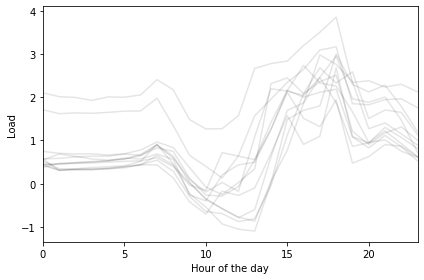

None

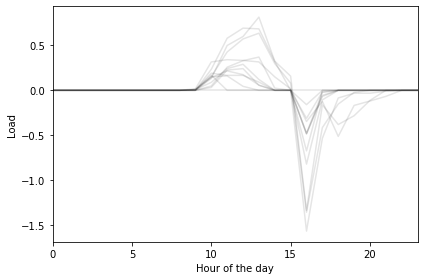

None

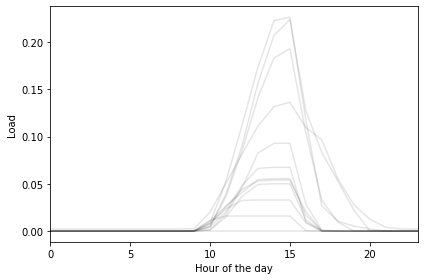

None

In [9]:
sa_id = 0

# examine battery operations for a single meter
battery_simulation = multi.battery_simulations.get(meter__sa_id=sa_id)
battery_intervalframe = battery_simulation.simulation.battery_intervalframe

# display average daily load before battery
display(plot_frame288(battery_simulation.pre_intervalframe.average_frame288))

# display average battery discharge
battery_intervalframe.aggregation_column = "kw"
display(plot_frame288(battery_intervalframe.average_frame288))

# display average battery state of charge
battery_intervalframe.aggregation_column = "charge"
charge_frame288 = battery_intervalframe.average_frame288
battery_intervalframe.aggregation_column = "capacity"
capacity_frame288 = battery_intervalframe.average_frame288
display(plot_frame288(charge_frame288/capacity_frame288))

In [10]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(battery_simulation__meter__sa_id=sa_id)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge (7.5 max kWh/day),0,232.500,kWh,0.1323,$/kWh,1,30.759750
1,energy,Energy Charge (9.75 max kWh/day),0,69.750,kWh,0.1504,$/kWh,1,10.490400
2,energy,Energy Charge (15 max kWh/day),0,162.750,kWh,0.32377,$/kWh,1,52.693568
3,energy,Energy Charge (22.5 max kWh/day),0,61.907,kWh,0.36377,$/kWh,1,22.519909
Total,,,,526.907,,,,,116.463627


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge (7.5 max kWh/day),0,232.500,kWh,0.1323,$/kWh,1,30.759750
1,energy,Energy Charge (9.75 max kWh/day),0,69.750,kWh,0.1504,$/kWh,1,10.490400
2,energy,Energy Charge (15 max kWh/day),0,162.750,kWh,0.32377,$/kWh,1,52.693568
3,energy,Energy Charge (22.5 max kWh/day),0,69.707,kWh,0.36377,$/kWh,1,25.357315
Total,,,,534.707,,,,,119.301033


In [11]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(battery_simulation__meter__sa_id=sa_id, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2018)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,0.664753,0.664753
2,0.465362,0.465740
3,0.279176,0.279611
4,0.239366,0.239679
5,0.206408,0.206181
6,0.166328,0.167552
7,0.201551,0.203072
8,0.200011,0.201688
9,0.210171,0.211818
10,0.240384,0.241575
